# Project Name and Description

## Contents
1. Frame the problem  and look at the big picture
2. Get the data
3. Explore and visualize the data to gain insights
4. Prepare the data to better expose the underlying patterns to machine learning algorithm
5. Explore many modesl; Select a model and train it
6. Fine-tune the model
7. Present your solution
8. Launch, monitor and maintain your system



# 1. Frame the problem

TODO

In [150]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from scipy.stats import kruskal, pearsonr

In [151]:
# Sklearn imports
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

In [152]:
# Custom-made utilities
from src.data_retrieval import fetch_data
from src.utilities import save_fig

In [153]:
# Some plotting settings
plt.rc('font', size=11)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

# 2. Getting the data

In [154]:
# Load data
df_full = df = fetch_data()
target = 'median_house_value'  # the name of the target variable
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [156]:
df['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [157]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


'images/distributions of numerical variables.png'

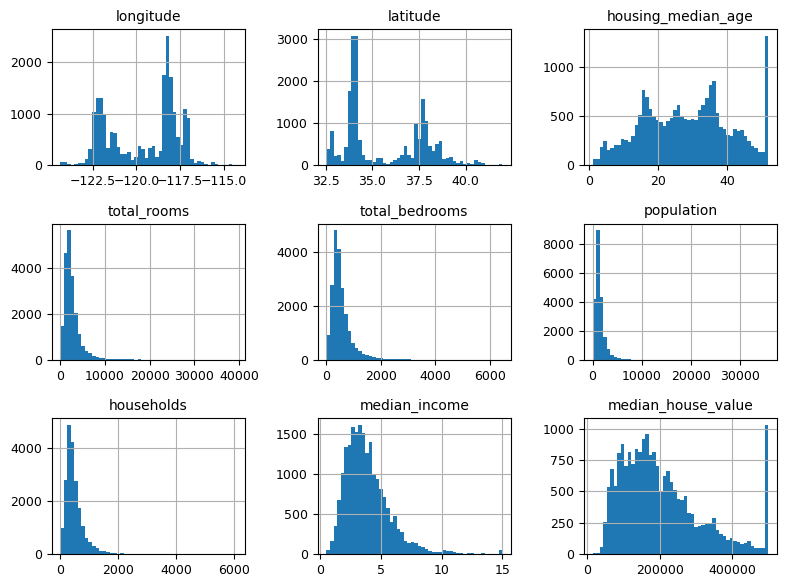

In [158]:
df.hist(bins=50, figsize=(8, 6))
save_fig("distributions of numerical variables")

## Train Test Split
Domain knowledge: because `median income` is important in predicting the target, the train-test split must be stratified on that feature.

In [159]:
# Make income category (temporary)
income_cat = pd.cut(df['median_income'],
                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                    right=False,
                    labels=[1, 2, 3, 4, 5])

'images/income categories.png'

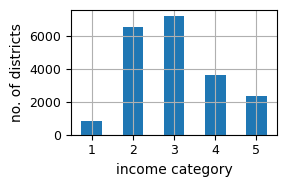

In [160]:
# Vizualise the categories
income_cat.value_counts().sort_index().plot.bar(rot=0, grid=True, figsize=(3,2))
plt.xlabel("income category")
plt.ylabel("no. of districts")
save_fig("income categories")

## Stratified split

In [161]:
# Stratified split
train_set, test_set = train_test_split(df_full, test_size=0.2, stratify=income_cat, random_state=42)

# 3. Explore the data

In [162]:
# 1. Put away the test set
test_set.to_csv("data/test_set.csv")

# 2. Also, save the train set
train_set.to_csv("data/train_set.csv")

# 2. Make an exploration subset
df = df_exploration = housing = train_set.copy()  # full because len(train_set) is small

'images/California.png'

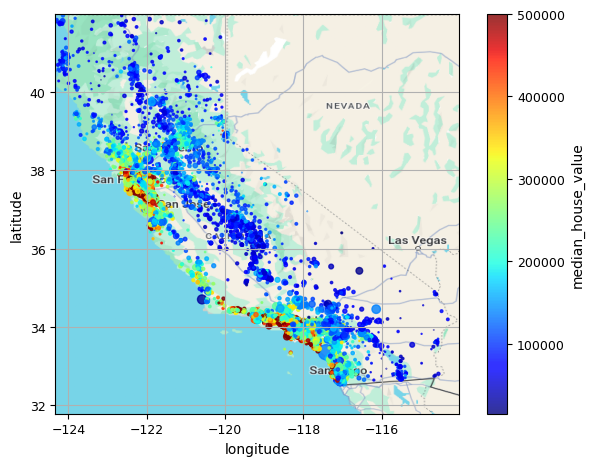

In [163]:
# Visualize on the map
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent = geo-coords

df.plot(kind='scatter', x='longitude', y='latitude', grid=True,
        s=df['population'] / 300, c=target, cmap='jet', colorbar=True, alpha=0.8,
        legend=True, sharex=True)
plt.axis(extent)

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
plt.imshow(pn, extent=extent)
save_fig("California")

In [164]:
# Experiment with DBSCAN
dbscan = DBSCAN(eps=0.25, min_samples=150, metric='euclidean')
df['cluster'] = dbscan.fit_predict(df[['longitude', 'latitude']])
df['cluster'].value_counts()

cluster
 1    7148
 0    3802
-1    2113
 2    1360
 4    1271
 3     610
 5     208
Name: count, dtype: int64

'images/DBSCAN.png'

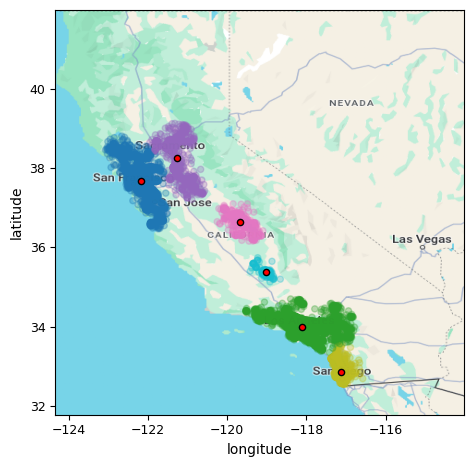

In [165]:
# Visualize the DBSCAN clusters
ax = plt.axes()

pn = plt.imread("images/[-124.34,-114.02,31.78,41.99].png")  # (553, 444, 4)
extent = [-124.34,-114.02, 31.78,41.99]  # photo extent
ax.imshow(pn, extent=extent)
plt.axis(extent)

# Plot the clusters
df[df['cluster'] != -1].plot(kind='scatter', x='longitude', y='latitude', c='cluster', 
                                            alpha=0.3, cmap='tab10', colorbar=False, ax=ax)

# Draw the cluster centroids
df_centroids = df[['longitude', 'latitude', 'cluster']].groupby('cluster').mean().drop(-1, axis=0).sort_index()
df_centroids.plot(kind='scatter', x='longitude', y='latitude', c='red', edgecolor='k', ax=ax)

save_fig("DBSCAN")

In [166]:
# Add a new feature: distance from the respective centroid

def func(row: pd.Series):
    if row['cluster'] == -1:
        return np.nan
    return ((row[['longitude', 'latitude']] - df_centroids.loc[row['cluster']])**2).sum() ** (1/2)

df["distance_from_centroid"] = df.apply(func, axis=1)
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,NEAR BAY,0,0.341508
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,<1H OCEAN,1,0.160812
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,INLAND,2,0.439921
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,INLAND,0,0.734263
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,<1H OCEAN,1,0.087449
1293,-121.62,39.75,20.0,1173.0,261.0,523.0,258.0,1.0625,92800.0,INLAND,-1,NaN
1034,-118.63,34.18,33.0,5252.0,760.0,2041.0,730.0,6.7977,389700.0,<1H OCEAN,1,0.561185
15293,-117.70,33.50,4.0,7474.0,1037.0,2969.0,1007.0,8.7591,434700.0,<1H OCEAN,1,0.635177
5007,-118.53,34.03,40.0,4350.0,763.0,1551.0,665.0,7.0318,500001.0,<1H OCEAN,1,0.430586
19122,-117.66,34.08,33.0,3659.0,590.0,1773.0,615.0,3.9227,157200.0,INLAND,1,0.449630


In [167]:
# Kruskal-Wallis test for dependence cluster->tagret (H0: no dependence)

alpha = 0.05
samples = [e[0] for e in df[['cluster', target]].groupby('cluster').agg(list).values]
res = kruskal(*samples)
pvalue = res.pvalue
print(f'p-value = {pvalue}\nreject H0?: {"yes" if pvalue < alpha else "no"}')

p-value = 0.0
reject H0?: yes


Kruskal-Wallis test showed that there is a strong dependence between the cluster and target feature.
We will make one-hot features out of the 'cluster' feature.

In [168]:
# Check Pearson's correlation
df['reverse_distance'] = (df['distance_from_centroid'].max() - df['distance_from_centroid']).fillna(0)
X,Y = df['reverse_distance'], df[target]

statistic, pvalue = pearsonr(X,Y)
statistic

0.23708130717633408

'images/correlation matrix.png'

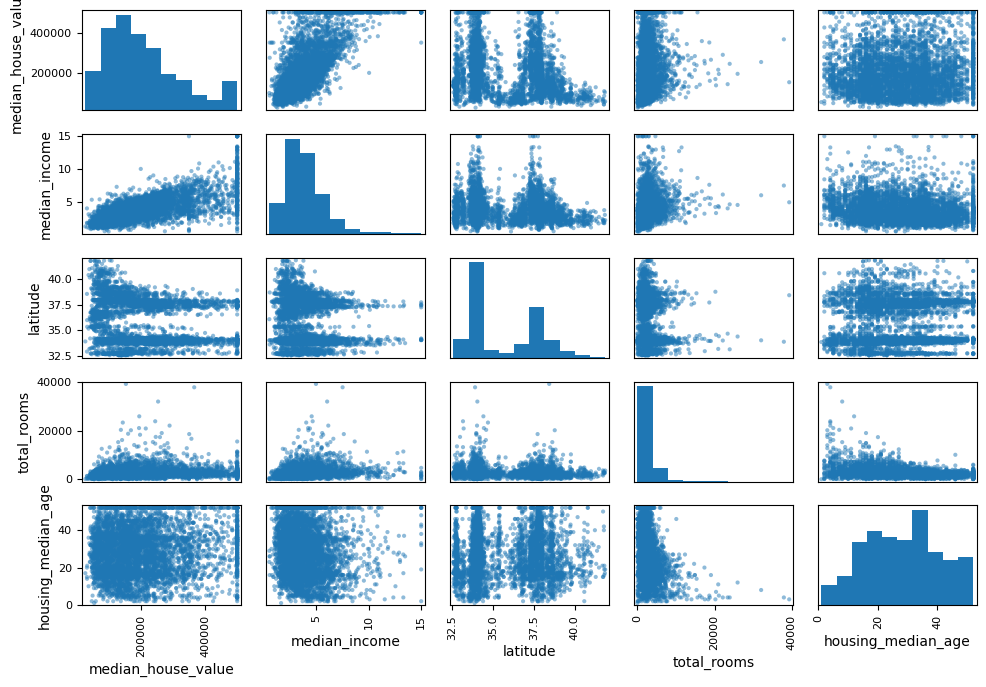

In [169]:
# Visualize the correlations
selected_features = [target, 'median_income', 'latitude', 'total_rooms', 'housing_median_age']
scatter_matrix(df[selected_features].sample(5_000), figsize=(10,7))
save_fig("correlation matrix")

median_house_value
500001.0    775
162500.0     97
137500.0     96
112500.0     84
187500.0     73
225000.0     70
350000.0     66
87500.0      61
150000.0     58
275000.0     53
100000.0     51
67500.0      44
175000.0     44
125000.0     42
250000.0     41
Name: count, dtype: int64

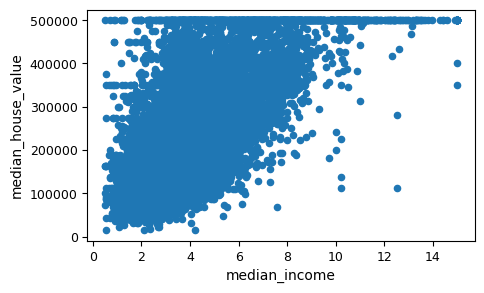

In [170]:
# Plot 'median_income' vs target
df.plot(kind='scatter', x='median_income', y=target, figsize=(5,3))
df[target].value_counts().head(15)

### Feature engineering: ratios


In [171]:
df["rooms_per_house"] = df['total_rooms'] / df['households']
df["bedrooms_ratio"] = df['total_bedrooms'] / df['total_rooms']
df["people_per_house"] = df['population'] / df['households']
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,cluster,distance_from_centroid,reverse_distance,rooms_per_house,bedrooms_ratio,people_per_house
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,173200.0,NEAR BAY,0,0.341508,1.147173,4.907480,0.216807,2.760827
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,194200.0,<1H OCEAN,1,0.160812,1.327868,5.738806,0.195925,3.029851
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,82300.0,INLAND,2,0.439921,1.048760,3.957935,0.271014,3.912046
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,120100.0,INLAND,0,0.734263,0.754417,5.308256,0.199548,1.930093
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,182100.0,<1H OCEAN,1,0.087449,1.401232,4.087879,0.260934,3.600000


In [172]:
# Compute correlations
df.select_dtypes(include='float').corr()[target].sort_values(key=abs, ascending=False)

median_house_value        1.000000
median_income             0.687369
bedrooms_ratio           -0.253567
reverse_distance          0.237081
rooms_per_house           0.151071
latitude                 -0.142290
total_rooms               0.132973
housing_median_age        0.107244
households                0.066395
longitude                -0.049937
total_bedrooms            0.049495
population               -0.025966
people_per_house         -0.022334
distance_from_centroid   -0.019840
Name: median_house_value, dtype: float64

### Quick and dirty linear regression

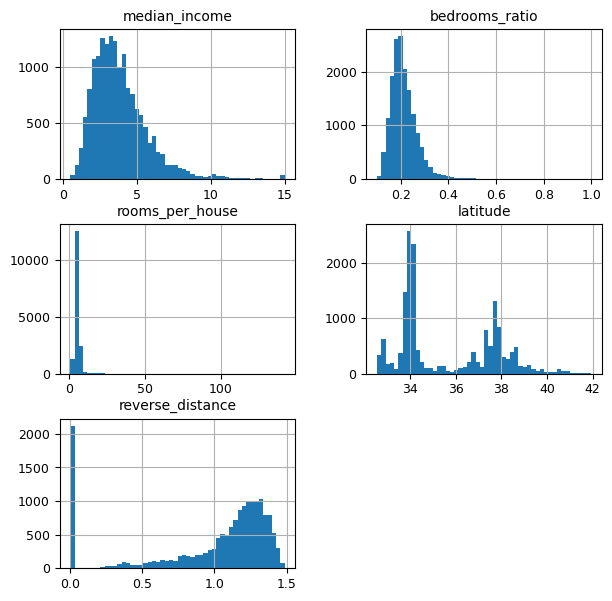

In [173]:
oh = pd.get_dummies(df['cluster'], drop_first=True).astype(float)
oh_interaction = oh.values * df['reverse_distance'].values.reshape(-1,1)

selected_features = ['median_income', 'bedrooms_ratio', 'rooms_per_house', 'latitude', 'reverse_distance']
df[selected_features].hist(bins=50, figsize=(7,7));

In [174]:
df["log_median_income"] = np.log(df['median_income'])
df["log_bedrooms_ratio"] = np.log(df['bedrooms_ratio'] + 0.01)
df["log_rooms_per_house"] = np.log(df['rooms_per_house'])
df['square_reverse_distance'] = np.square(df['reverse_distance'])
df['minmax_reverse_distance'] = (df['reverse_distance'] - df['reverse_distance'].min()) / (df['reverse_distance'].max() - df['reverse_distance'].min())
df['stnaderdized_reverse_distance'] = (df['minmax_reverse_distance'] - df['minmax_reverse_distance'].mean()) / df['minmax_reverse_distance'].std()

In [175]:
df.select_dtypes(include=[np.number]).corr()[target].sort_values(key=abs, ascending=False)

median_house_value               1.000000
median_income                    0.687369
log_median_income                0.649521
log_bedrooms_ratio              -0.323137
bedrooms_ratio                  -0.253567
stnaderdized_reverse_distance    0.237081
minmax_reverse_distance          0.237081
reverse_distance                 0.237081
log_rooms_per_house              0.236386
square_reverse_distance          0.182365
rooms_per_house                  0.151071
latitude                        -0.142290
total_rooms                      0.132973
housing_median_age               0.107244
cluster                         -0.106315
households                       0.066395
longitude                       -0.049937
total_bedrooms                   0.049495
population                      -0.025966
people_per_house                -0.022334
distance_from_centroid          -0.019840
Name: median_house_value, dtype: float64

In [176]:
predictors = ['log_median_income', 'log_bedrooms_ratio', 'reverse_distance', 'log_rooms_per_house', 'latitude']

mask = (df['log_median_income'] < df['log_median_income'].max()) & (df[target] < df[target].max())
df = df[mask]

df.dropna(subset=['log_bedrooms_ratio'], inplace=True)

X = (df[predictors] - df[predictors].mean(axis=0)) / df[predictors].std(axis=0)
oh = pd.get_dummies(df['cluster'], drop_first=True).astype(float)
X = pd.concat([X, oh], axis=1)
X.columns = X.columns.astype(str)
y = df[target]

md = LinearRegression().fit(X,y)
rsq = md.score(X,y)
rsq

/tmp/ipykernel_7062/1756058032.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['log_bedrooms_ratio'], inplace=True)


0.5046579906293172

In [177]:
weights = pd.Series(md.coef_, index=X.columns)
weights.sort_values(key=abs, ascending=False)

5                     -80645.585199
3                     -69051.159337
log_median_income      59655.276399
0                      48363.427717
4                     -27134.361977
2                     -23935.423551
log_bedrooms_ratio     16822.148123
latitude              -13265.239643
reverse_distance       12434.763059
log_rooms_per_house     4490.543809
1                       1376.737675
dtype: float64

In [178]:
# RMSE
ytrue = y
ypred = md.predict(X)

rmse = mean_squared_error(ytrue, ypred) ** (1/2)
rmse

68693.98872560271

### Revert to the original train dataset

In [179]:
X_train = df = pd.read_csv("data/train_set.csv", index_col=0)
y_train = ytrue = y = X_train.pop(target)


In [180]:
# Imputation on the numerical features
df_numerical_features = df.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy='median').fit(df_numerical_features)
X_train_numerical_imputed = imputer.transform(df_numerical_features)
df_numerical_features_imputed = pd.DataFrame(X_train_numerical_imputed, 
                                             columns=df_numerical_features.columns,
                                             index=df_numerical_features.index)
imputer.statistics_

array([-118.5   ,   34.26  ,   29.    , 2126.5   ,  435.    , 1167.    ,
        410.    ,    3.5394])

In [181]:
# Handling the categorical features
df_categorical_features = df[['ocean_proximity']]
encoder = OrdinalEncoder()
categorical_features_encoded = encoder.fit_transform(df_categorical_features)
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [182]:
# One Hot Encoding
oh = OneHotEncoder(sparse_output=False)
categorical_features_encoded = oh.fit_transform(df_categorical_features)
categorical_features_encoded, oh.categories_

(array([[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        ...,
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.]]),
 [array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
        dtype=object)])

In [185]:
oh.feature_names_in_, oh.get_feature_names_out()

(array(['ocean_proximity'], dtype=object),
 array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
        'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
        'ocean_proximity_NEAR OCEAN'], dtype=object))

In [183]:
# pandas.get_dummies
pd.get_dummies(df, drop_first=True)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,False,False,True,False
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,False,False,False,False
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,True,False,False,False
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,True,False,False,False
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
14471,-117.11,32.69,37.0,2395.0,627.0,2489.0,599.0,1.5933,False,False,False,True
20081,-117.20,33.70,23.0,6323.0,1196.0,1984.0,1124.0,2.3276,False,False,False,False
18541,-122.14,40.07,31.0,2053.0,465.0,1193.0,447.0,1.4923,True,False,False,False
19715,-118.36,33.94,39.0,1390.0,410.0,1666.0,371.0,3.3056,False,False,False,False


In [184]:
# Replacing a categorical feature with numerical / embedding
categorical_feature = 'ocean_proximity'
df[categorical_feature] = pd.Categorical(df[categorical_feature],
                                        categories=['ISLAND', 'NEAR OCEAN', 'NEAR BAY', '<1H OCEAN', 'INLAND'],
                                        ordered=True).codes
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17449,-122.29,38.00,16.0,4986.0,1081.0,2805.0,1016.0,4.0250,2
17064,-118.01,33.86,29.0,2307.0,452.0,1218.0,402.0,3.4306,3
17341,-121.56,38.58,32.0,2070.0,561.0,2046.0,523.0,1.9426,4
7160,-121.94,38.37,17.0,7973.0,1591.0,2899.0,1502.0,2.8357,4
20462,-118.10,34.08,21.0,1349.0,352.0,1188.0,330.0,2.5000,3
1293,-121.62,39.75,20.0,1173.0,261.0,523.0,258.0,1.0625,4
1034,-118.63,34.18,33.0,5252.0,760.0,2041.0,730.0,6.7977,3
15293,-117.70,33.50,4.0,7474.0,1037.0,2969.0,1007.0,8.7591,3
5007,-118.53,34.03,40.0,4350.0,763.0,1551.0,665.0,7.0318,3
19122,-117.66,34.08,33.0,3659.0,590.0,1773.0,615.0,3.9227,4
